# Fantasy Premier League EDA

The Notebook has a look at key performance metrics for fantasy league players or assets as the community likes to call them. More often than not, we just have to look at the data in the right way than go for advanced Machine Learning to make the right decisions.

In [3]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA

In [4]:
#directory change to access scripts - run once only
%cd ../scripts

/home/sitwala/linuxdevs/fpl/scripts


## FPL Data Import 

In [5]:
# import functions from the scripts folder and call the dataframes
from fpl_import import *

raw_json = get_raw_fpl_tables()
slim_elements_df = combine_player_teams(raw_json)
slim_elements_df = slim_elements_df["player_data"]
slim_elements_df.head()


,id,second_name,team,element_type,selected_by_percent,now_cost,minutes,transfers_in,value_season,total_points,ict_index,web_name,form,position,value
0,1,Leno,Arsenal,1,0.9,45,360,68159,2.2,10,8.5,Leno,1.2,Goalkeeper,2.2
3,4,Aubameyang,Arsenal,4,1.3,96,1036,742898,4.6,44,92.9,Aubameyang,0.0,Forward,4.6
4,5,Soares,Arsenal,2,0.3,42,829,29982,5.7,24,34.8,Cédric,2.8,Defender,5.7
5,6,Lacazette,Arsenal,4,8.7,84,1523,1605340,9.6,81,144.1,Lacazette,4.6,Forward,9.6
6,7,Xhaka,Arsenal,3,0.3,48,1455,29690,6.9,33,68.4,Xhaka,2.2,Midfielder,6.9


## Points and Value Distributions by Position. 
This can help us to see which positions have a better concetration of good performers

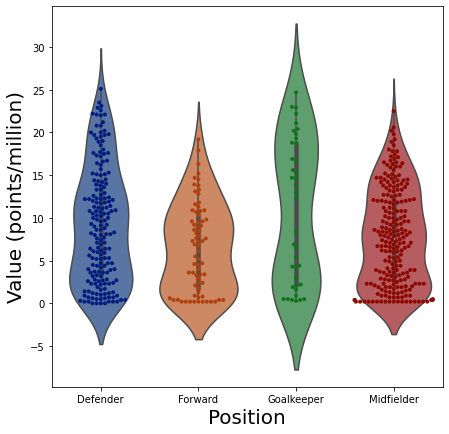

In [6]:
fig, ax = plt.subplots(figsize =(7,7))
sns.set()
sns.violinplot(x=slim_elements_df.sort_values(by = "position", ascending=True).position,y=slim_elements_df.value, ax = ax)
sns.swarmplot(x=slim_elements_df.sort_values(by = "position", ascending=True).position,
              y=slim_elements_df.value, ax = ax, palette = "dark", size = 4)
plt.ylabel("Value (points/million)", fontsize = 20)
plt.xlabel("Position", fontsize = 20)
plt.savefig("../images/value_violin.png")

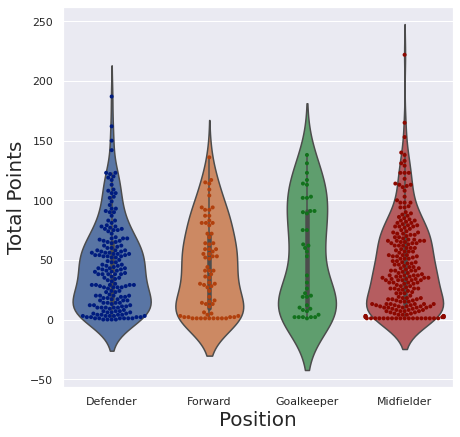

In [7]:
fig, ax = plt.subplots(figsize =(7,7))
sns.set()
sns.violinplot(x=slim_elements_df.sort_values(by = "position", ascending=True).position,y=slim_elements_df.total_points, ax = ax)
sns.swarmplot(x=slim_elements_df.sort_values(by = "position", ascending=True).position,
              y=slim_elements_df.total_points, ax = ax,palette = "dark", size = 4)
plt.ylabel("Total Points", fontsize = 20)
plt.xlabel("Position", fontsize = 20)
plt.savefig("../images/points_violin.png")



## Top Points Players by Position



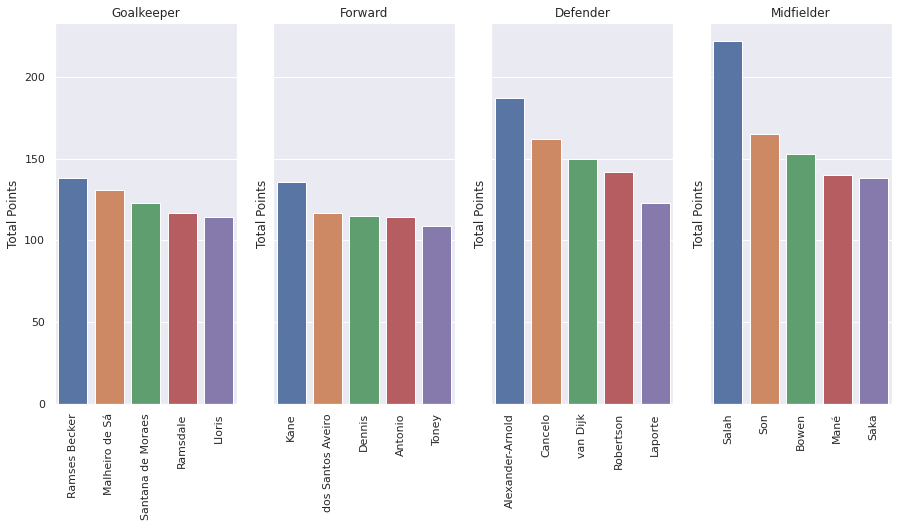

In [8]:
fig, ax = plt.subplots(1,4, figsize =(15,7), sharey= True)
positions = list(slim_elements_df.position.unique())
n=0
for position in positions:

    #filter for position and pick top 5
    filtered_df = slim_elements_df[slim_elements_df.position == position]
    filtered_df = filtered_df.nlargest(5,"total_points")

    #plots
    sns.barplot(x=filtered_df.second_name, y=filtered_df.total_points, ax =  ax[n] )
    ax[n].set_title(position)
    ax[n].set_ylabel("Total Points")
    ax[n].set_xlabel("")
    ax[n].set_xticklabels(filtered_df.second_name, rotation= 90 )   
    n += 1
    plt.savefig("../images/points_top5.png")
  


## Top Value Players by Position

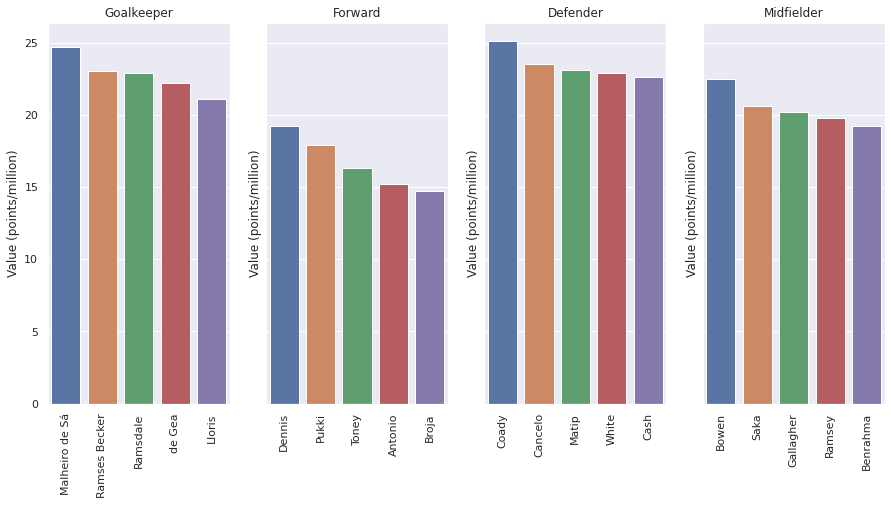

In [9]:
fig, ax = plt.subplots(1,4, figsize =(15,7), sharey= True)
positions = list(slim_elements_df.position.unique())
n=0
for position in positions:

    #filter for position and pick top 5
    filtered_df = slim_elements_df[slim_elements_df.position == position]
    filtered_df = filtered_df.nlargest(5,"value")

    #plots
    sns.barplot(x=filtered_df.second_name, y=filtered_df.value, ax =  ax[n] )
    ax[n].set_title(position)
    ax[n].set_ylabel("Value (points/million)")
    ax[n].set_xlabel("")
    ax[n].set_xticklabels(filtered_df.second_name, rotation= 90 )   
    n += 1
  
plt.savefig("../images/value_top5.png")

## Top Form Players by Position

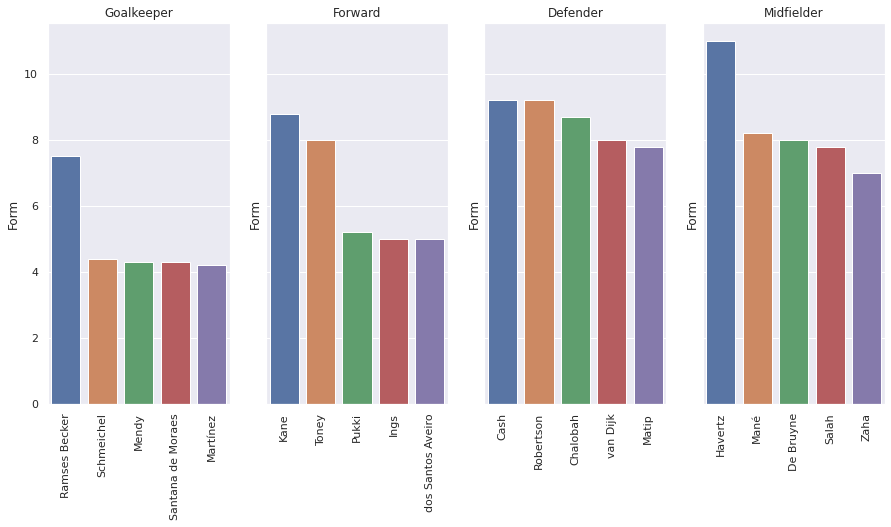

In [10]:
fig, ax = plt.subplots(1,4, figsize =(15,7), sharey= True)
positions = list(slim_elements_df.position.unique())
n=0
for position in positions:

    #filter for position and pick top 5
    filtered_df = slim_elements_df[slim_elements_df.position == position]
    filtered_df = filtered_df.nlargest(5,"form")

    #plots
    sns.barplot(x=filtered_df.second_name, y=filtered_df.form, ax =  ax[n] )
    ax[n].set_title(position)
    ax[n].set_ylabel("Form")
    ax[n].set_xlabel("")
    ax[n].set_xticklabels(filtered_df.second_name, rotation= 90 )   
    n += 1
    plt.savefig("../images/form_top5.png")
  

## Player performance variation => who are the most consistent players?

In [11]:
#get player historical data for the season
player_id = slim_elements_df.id
all_players_hist = combine_all_players_hist(player_id)

# get player performance variation for 500 minutes minimum and select the top 20
player_variation = compute_player_variation(all_players_hist,500,20)
player_variation.head()

,Mean,Std,player,CV,second_name,position,ict_index,minutes,now_cost,team
element,,,,,,,,,,
135,9.000000,4.381780,135,0.486864,Chilwell,Defender,54.0,540.0,5.6,Chelsea
233,8.222222,5.753483,233,0.699748,Salah,Midfielder,362.3,2259.0,13.3,Liverpool
237,7.192308,3.898915,237,0.542095,Alexander-Arnold,Defender,235.5,2313.0,8.5,Liverpool
234,6.454545,3.912462,234,0.606156,Robertson,Defender,153.1,1934.0,7.2,Liverpool
142,6.411765,7.323411,142,1.142183,James,Defender,119.4,1184.0,6.2,Chelsea


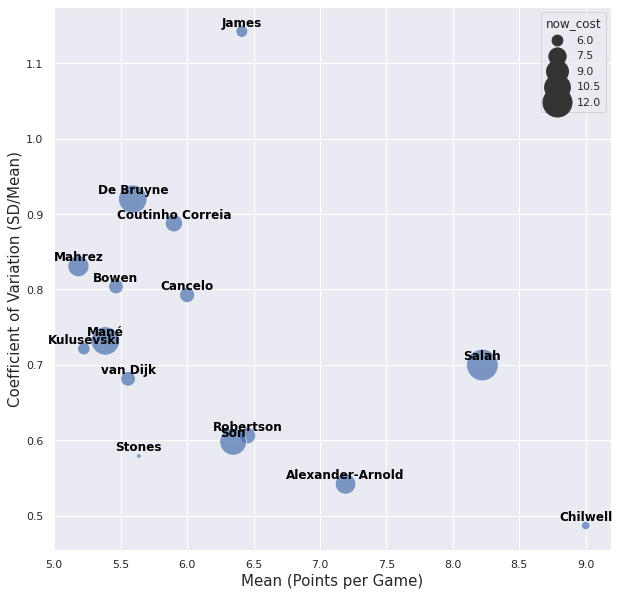

In [12]:
fig, ax = plt.subplots(figsize = (10,10))
sns.set()
sns.scatterplot(x = player_variation.Mean, y= player_variation.CV, size = player_variation.now_cost,   sizes=(20, 1000), alpha = 0.7, ax = ax)



#For each point, we add a text inside the bubble
for line in range(0,player_variation.shape[0]):
     ax.text(player_variation.Mean.iloc[line], player_variation.CV.iloc[line]+0.007, player_variation.second_name.iloc[line], horizontalalignment='center', size='medium', color='black', weight='semibold')

 
ax.set_xlabel("Mean (Points per Game)",fontsize=15)
ax.set_ylabel("Coefficient of Variation (SD/Mean)",fontsize=15)
plt.savefig("../images/volatility.png")
 

## Fixture Difficulty Rating Faced

In [22]:
# use the difficulty methods to get opponent difficulty for next four fixtures
from difficulty import team_difficulty
gameweek = get_current_gameweek()
diff_df = team_difficulty(gameweek+1,gameweek+8)
diff_df = diff_df["totals"]
diff_df.head()

,team,opponent_difficulty,number_games
0,Arsenal,24,9
1,Aston Villa,21,7
2,Brentford,23,8
3,Brighton,29,9
4,Burnley,28,10


In [23]:
# add a per game column because of teams blanking (lesss fixtures)
diff_df["per_game_diff"] = diff_df.opponent_difficulty/diff_df.number_games
diff_df = diff_df.sort_values(by="per_game_diff" , ascending= True)

#print the table
print(tabulate(diff_df, headers='keys', tablefmt='psql'))

+----+----------------+-----------------------+----------------+-----------------+
|    | team           |   opponent_difficulty |   number_games |   per_game_diff |
|----+----------------+-----------------------+----------------+-----------------|
|  6 | Crystal Palace |                    20 |              8 |         2.5     |
|  9 | Leicester      |                    23 |              9 |         2.55556 |
| 11 | Man City       |                    21 |              8 |         2.625   |
|  5 | Chelsea        |                    21 |              8 |         2.625   |
|  0 | Arsenal        |                    24 |              9 |         2.66667 |
| 10 | Liverpool      |                    22 |              8 |         2.75    |
| 16 | Spurs          |                    22 |              8 |         2.75    |
| 15 | Southampton    |                    25 |              9 |         2.77778 |
|  4 | Burnley        |                    28 |             10 |         2.8     |
|  8

##Kenerl PCA Decomposition

In [24]:
slim_elements_df.head(6)

,id,second_name,team,element_type,selected_by_percent,now_cost,minutes,transfers_in,value_season,total_points,ict_index,web_name,form,position,value
0,1,Leno,Arsenal,1,0.9,45,360,68159,2.2,10,8.5,Leno,1.2,Goalkeeper,2.2
3,4,Aubameyang,Arsenal,4,1.3,96,1036,742898,4.6,44,92.9,Aubameyang,0.0,Forward,4.6
4,5,Soares,Arsenal,2,0.3,42,829,29982,5.7,24,34.8,Cédric,2.8,Defender,5.7
5,6,Lacazette,Arsenal,4,8.7,84,1523,1605340,9.6,81,144.1,Lacazette,4.6,Forward,9.6
6,7,Xhaka,Arsenal,3,0.3,48,1455,29690,6.9,33,68.4,Xhaka,2.2,Midfielder,6.9
7,8,Marí,Arsenal,2,0.1,42,180,5760,0.2,1,7.9,Marí,0.0,Defender,0.2


In [25]:
diff_df.head(6)

,team,opponent_difficulty,number_games,per_game_diff
6,Crystal Palace,20,8,2.500000
9,Leicester,23,9,2.555556
11,Man City,21,8,2.625000
5,Chelsea,21,8,2.625000
0,Arsenal,24,9,2.666667
10,Liverpool,22,8,2.750000


### First we attach the fixture difficulty to each player using the team field

In [26]:
joined_df = slim_elements_df.set_index("team").join(diff_df.set_index("team"))
joined_df.reset_index(inplace = True)
joined_df.head(6)

,team,id,second_name,element_type,selected_by_percent,now_cost,minutes,transfers_in,value_season,total_points,ict_index,web_name,form,position,value,opponent_difficulty,number_games,per_game_diff
0,Arsenal,1,Leno,1,0.9,45,360,68159,2.2,10,8.5,Leno,1.2,Goalkeeper,2.2,24,9,2.666667
1,Arsenal,4,Aubameyang,4,1.3,96,1036,742898,4.6,44,92.9,Aubameyang,0.0,Forward,4.6,24,9,2.666667
2,Arsenal,5,Soares,2,0.3,42,829,29982,5.7,24,34.8,Cédric,2.8,Defender,5.7,24,9,2.666667
3,Arsenal,6,Lacazette,4,8.7,84,1523,1605340,9.6,81,144.1,Lacazette,4.6,Forward,9.6,24,9,2.666667
4,Arsenal,7,Xhaka,3,0.3,48,1455,29690,6.9,33,68.4,Xhaka,2.2,Midfielder,6.9,24,9,2.666667
5,Arsenal,8,Marí,2,0.1,42,180,5760,0.2,1,7.9,Marí,0.0,Defender,0.2,24,9,2.666667


### Now we try to cluster players by looking at total points, form, value and difficulty of fixtures coming. This is usually a decion FPL Managers need to make
reference: https://www.statology.org/scree-plot-python/

In [27]:
#define columns to use for PCA
pca_columns = ["total_points","form","value","ict_index"]
df = joined_df.loc[:,pca_columns ]
df.head(6)

,total_points,form,value,ict_index
0,10,1.2,2.2,8.5
1,44,0.0,4.6,92.9
2,24,2.8,5.7,34.8
3,81,4.6,9.6,144.1
4,33,2.2,6.9,68.4
5,1,0.0,0.2,7.9


In [28]:
#define scaler
scaler = StandardScaler()

#create copy of DataFrame
scaled_df=df.copy()

#created scaled version of DataFrame
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

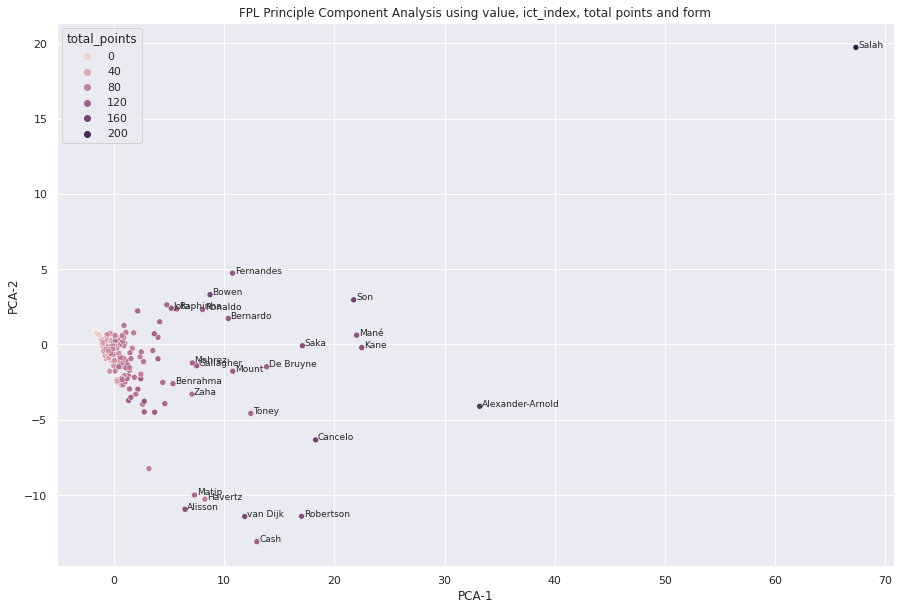

In [29]:
# try Kernel PCA
transformer = KernelPCA(n_components=4, kernel='poly')

#fit PCA model to data
pca_fit_k = transformer.fit(scaled_df)

fig, ax = plt.subplots(figsize=(15,10))
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca_fit_k )])
Xt = pipe.fit_transform(df)
sns.scatterplot(x=Xt[:,0],y= Xt[:,1], hue=joined_df.total_points, ax = ax, sizes = 50)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("FPL Principle Component Analysis using value, ict_index, total points and form")

names = joined_df.web_name
for i, txt in enumerate(names):
    if Xt[i,0] > 5:
        ax.annotate(txt, (Xt[i,0]+0.2, Xt[i,1]), fontsize=9)
    else:
        pass
plt.savefig("../images/pca_plot.png")
plt.show()

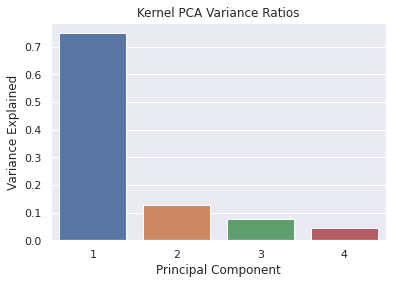

In [21]:
PC_values = np.arange(pca_fit_k.n_components) + 1
explained_variance = np.var(Xt, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
sns.barplot(x=PC_values, y=explained_variance_ratio)
plt.title('Kernel PCA Variance Ratios')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.savefig("../images/variance_ratios.png")
plt.show()